<a href="https://colab.research.google.com/github/phsimon/LSTM_Last.fm/blob/main/LSTM/target_ten_lastFM_1k_LSTM_Embeddings_multilabel_session_dataset_filtered_item.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook provides a recommender engine and use lastFM 1k  dataset (a filtered and sampled one)
The Recurrent model is built as follow:


*  Input Layer: a sequence (len = max_sequence_train) of songid representing the history of the user

*   Embedding Layer: this layer expand each songid in a higher dimension (embedding size) - now each song of the sequence is represented by a vector of floats
*   Recurrent Layer: this layer process the embedding layer to product a sequence of vector (size: the number of unit of the recurrent layer). We can stack many reccurent layer. as it is reccurent layer, for one sequence, the "n" output take into account the "n-1" output. As we want to have only one vector in output, we set "return_sequence=False.

*   (Dense) Layer : this layer outputs a vecteur whom size is the size of the catalog. "Softmax" is used to identify the highest value and output the index. so that with Softmax, this layer output a prediction




#Initialization and model definition

In [ ]:
#%tensorflow_version 1.x
import tensorflow
print(tensorflow.__version__)

2.4.1


In [ ]:
import keras
print(keras.__version__)

2.4.3


In [ ]:
#init dico for saving results
average_measure={}
average_measure['PREC'],average_measure['MAP'], average_measure['MRR'],average_measure['NDCG'],average_measure['recall'] =[],[],[],[],[]

In [ ]:
# paramètres
batchsize=64
Shift=10
max_sequence_label=10
max_sequence_train=10
num_prediction=10
THRESHOLD_HISTORY=2*max_sequence_train-1
THRESHOLD_ITEM=19
outlier_excluded=0
ratio_sampling_top=1

In [ ]:
# function and procedure
import datetime
from time import time
from keras.layers import Input, Dense, Dropout, TimeDistributed, Attention
from keras.utils import np_utils, plot_model,Sequence
from keras.models import Model
from keras.layers import Embedding
from keras.layers import Flatten, Reshape, Permute
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU,SimpleRNN,ConvLSTM2D
from keras.callbacks import EarlyStopping,TensorBoard
import tensorflow as tf
import keras.backend as K

import numpy as np
 
def custom_precision(y_true,y_pred):
    z=tf.cast(y_true,tf.int64)
    index_prediction=tf.nn.top_k(y_pred,k=num_prediction)
    index_target=tf.nn.top_k(z,k=num_prediction)
    true_positive=tf.sets.intersection(index_prediction.indices,index_target.indices)
    precision=tf.count_nonzero(true_positive.values)
    precision_summary=tf.cast(precision,tf.float32)
    return precision_summary/(num_prediction*batchsize)

def build_model(one_hot_size,sequence_size,k_reg=None,b_reg=None,r_reg=None,o_reg=None):
    '''
    '''
    main_input=Input(shape=(sequence_size,),dtype='float32',name='main_input')
    print(main_input.shape)
    # This embedding layer will encode the input sequence
    b = Embedding(output_dim=embedding_size, input_dim=one_hot_size+1,name='my_embeddings')(main_input)
    print("embedding shape {} and type {} ".format(b.shape,type(b)))
    #b= Attention(name='attention_weight')([b,b])
    c=LSTM(LSTM_size,dropout=dropout_lstm_value,name='my_LSTM', kernel_regularizer=None, bias_regularizer=None,activity_regularizer=None, recurrent_regularizer=r_reg, return_sequences=True)(b)
    #c=LSTM(LSTM_size,dropout=dropout_lstm_value,name='my_LSTM_2', kernel_regularizer=None, bias_regularizer=None,activity_regularizer=None, recurrent_regularizer=r_reg, return_sequences=True)(c)
    #d=Dense(one_hot_size,activation='softmax')(c)
    d=TimeDistributed(Dense(one_hot_size,activation='softmax'))(c)
   
    model=Model(inputs=main_input, outputs=d)
    #model.compile(optimizer='rmsprop', loss="binary_crossentropy", metrics=['binary_accuracy',custom_precision])
    model.compile(optimizer='rmsprop', loss="sparse_categorical_crossentropy", metrics=['sparse_categorical_accuracy'])
    return model


def LastFM_vectorize_sequence(sequence,dimension,liste_item_sorted):
    '''
        :param: sequences : list liste d'ids de films
        :param: dimension : int nombre de films possible (taille du vocabulaire)
        :param: liste_item_sorted: liste des itemids triés par ordre croissant
        :return:results liste de taille dimension (contentant des 1 au rang d'un film vu)
    '''
    result=np.zeros((dimension,1))
    
    # on ordonne la sequence
    # en fait ce n'est pas utile
    # sequence.sort()
    for StockCode in sequence:
        result[liste_item_sorted.index(StockCode)]=1    
    return result   

def LastFM_normalize_liste(vector,norme=1.0):
    '''
        :param: vector : list liste de 0 avec des 1 à chaque fois qu'un film a été vu
        :param: norme : int valeur max de la somme des valeurs du vecteur après normalisation
        :return:results liste normalisée (avec des quotients à la place des 1 dès qu'il y en a plus de un, de manière à ce que la somme fasse 1 )
    '''
    len_vector=len(vector)
    for i in range(len_vector):
        vector[i]/=float(norme)/float(len_vector)    
    return vector   

class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, data_source, list_IDs, labels, batch_size=batchsize, dim_train=(max_sequence_train,), dim_label=(max_sequence_label,),n_channels=1,
                 n_classes=0, shuffle=True):
        'Initialization'
        self.data_source=data_source
        self.dim_train = dim_train
        self.dim_test=dim_label
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        #print("number of users per epoch \n",len(self.list_IDs))
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size, self.dim_train),dtype=int)
        if max_sequence_label>1:
          y = np.zeros((self.batch_size, self.dim_test,1), dtype=int)
        else:
          y = np.zeros((self.batch_size, self.dim_test), dtype=int)  
        # Generate data
        #print("X shape",X.shape)
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = self.data_source[ID]
            
            # Store class
            if max_sequence_label > 1:
              generated_label=np.reshape(self.labels[ID],(max_sequence_label,1))
            else:
              generated_label=np.reshape(self.labels[ID],(max_sequence_label,))  
            y[i] = generated_label
 
        return X, y



In [ ]:
import pandas as pd

In [ ]:
#@title Choose if you want to rely on sampled dataset or no...

Sample = "False" #@param ["True", "False"] {allow-input: true}


In [ ]:
SAMPLED=Sample

In [ ]:
SAMPLED=False
'''my_path="/content/drive/My Drive/ColabNotebooks/publication/LastFM-1k - Sample - 5.5k Items/"

testfile="lfm1k_tracks_sequences_test_sample_0p07.csv"
trainfile="lfm1k_tracks_sequences_train_sample_0p07.csv"
validationfile="lfm1k_tracks_sequences_valid_sample_0p07.csv"'''

if SAMPLED:
  my_path="/content/drive/My Drive/ColabNotebooks/publication/Bioman-Paper/LastFM-1k-Session-Based/Sample Data/"

  testfile="lastfm-1k_session-based_records_test_sample.csv"
  trainfile="lastfm-1k_session-based_records_train_sample.csv"
else:
  my_path="/content/drive/My Drive/ColabNotebooks/publication/Bioman-Paper/LastFM-1k-Session-Based/Whole Data/"

  testfile="lastfm-1k_session-based_records_test.csv"
  trainfile="lastfm-1k_session-based_records_train.csv"



In [ ]:
# lecture des fichiers 
data_train=pd.read_csv(my_path+trainfile,header=0,dtype='int32')
data_test=pd.read_csv(my_path+testfile,header=0,dtype='int32')


In [ ]:
# echantillonage pour accélerer les test
data_train=data_train.sample(frac=ratio_sampling_top, replace=False, random_state=1)

In [ ]:
len(data_train)

504215

In [ ]:
nb_user,nb_ligne=data_test.shape
print(nb_user,nb_ligne)

126559 20


#Dataset building

In [ ]:
# Building the item set
liste_item_1=[]
liste_item_2=[]
for user in data_train.index:
  liste_item_1.append(data_train.loc[user])
for user in data_test.index:
  liste_item_1.append(data_test.loc[user])
for x in liste_item_1:
  for y in x:
    liste_item_2.append(y)

print(len(liste_item_2))


KeyboardInterrupt: ignored

In [ ]:
len(np.unique(liste_item_2))

In [ ]:
import matplotlib.pyplot as plt
#plt.hist(liste_item_2,range=(1,20000),bins=1000)
plt.hist(liste_item_2,bins=30)


In [ ]:
from collections import Counter
ma_liste=Counter(liste_item_2).most_common()
ma_liste=ma_liste[1:] # on ne prend pas zero...
top1000=[x[0] for x in ma_liste if x[1] > THRESHOLD_ITEM]
histo_top1000=[x[1] for x in ma_liste]

In [ ]:
len(top1000)

In [ ]:
plt.plot(histo_top1000[1:100],'.')


In [ ]:
top1000_tri=sorted(list(set(top1000)))

In [ ]:
ma_liste[:10]

In [ ]:
# filter dataset to retain only top1000 item in data_train
data_train_top1000=[]
only_top1000=[]
for user in data_train.index:
  history=data_train.loc[user]
  only_top1000=[x for x in history if x in top1000_tri[outlier_excluded:]]
  while len(only_top1000) < len(history):
    only_top1000+=[0]
  data_train_top1000.append(only_top1000)  
data_train_top1000=pd.DataFrame(data_train_top1000)
print(data_train_top1000.head())



In [ ]:
# filter dataset to retain only top1000 item in data_set
data_test_top1000=[]
only_top1000=[]
for user in data_test.index:
  history=data_test.loc[user]
  only_top1000=[x for x in history if x in top1000_tri[outlier_excluded:]]
  while len(only_top1000) < len(history):
    only_top1000+=[0]
  data_test_top1000.append(only_top1000)  
data_test_top1000=pd.DataFrame(data_test_top1000)
print(data_test_top1000.head())

In [ ]:
liste_item_tri=sorted(list(set(liste_item_2)))
liste_item_tri.remove(0)
print(len(liste_item_tri))

In [ ]:
# re_index the content to have the lowest number so that one-hot will be smaller
song_2_int={i:j+1 for j,i in enumerate(liste_item_tri)}
int_2_song={(i+1):j for i,j in enumerate(liste_item_tri)}
liste_item_tri_int=[song_2_int[k] for k in liste_item_tri]

In [ ]:
song_2_int[1000]
int_2_song[992]

In [ ]:
# re_index the content to have the lowest number so that one-hot will be smaller
song_top1000_2_int={i:j+1 for j,i in enumerate(top1000_tri)}
int_2_song_top1000={i+1:j for i,j in enumerate(top1000_tri)}
top1000_tri_int=[song_top1000_2_int[k] for k in top1000_tri]

In [ ]:
len(song_top1000_2_int)

In [ ]:
history_size=[np.count_nonzero(data_train.loc[i]) for i in data_train.index]
len(history_size)

In [ ]:
import matplotlib.pyplot as plt
plt.hist(history_size,range=(0,20),bins=20)

Sélection des user selon la taille de leur historique

In [ ]:
history_top1000_size=[np.count_nonzero(data_train_top1000.loc[i]) for i in data_train_top1000.index]
len(history_top1000_size)

In [ ]:
#compactage historique pour ne pas avoir de doublon dans le train
data_train_top1000_without_doublon=[]
for i in data_train_top1000.index:
  history_without_doublon=[]
  history=data_train_top1000.loc[i]
  for item in history:
    if item not in history_without_doublon:
       history_without_doublon.append(int(item))
  while len(history_without_doublon) < len(history):
    history_without_doublon+=[0]
  data_train_top1000_without_doublon.append(history_without_doublon) 
data_train_top1000_without_doublon=pd.DataFrame(data_train_top1000_without_doublon)    

In [ ]:
#compactage historique pour ne pas avoir de doublon dans le test
data_test_top1000_without_doublon=[]
for i in data_test_top1000.index:
  history_without_doublon=[]
  history=data_test_top1000.loc[i]
  for item in history:
    if item not in history_without_doublon:
       history_without_doublon.append(int(item))
  while len(history_without_doublon) < len(history):
    history_without_doublon+=[0]
  data_test_top1000_without_doublon.append(history_without_doublon)   
data_test_top1000_without_doublon=pd.DataFrame(data_test_top1000_without_doublon)  

In [ ]:
len(data_train_top1000_without_doublon)

In [ ]:
data_train_top1000_without_doublon.head()

In [ ]:
plt.hist(history_top1000_size,range=(0,20),bins=20)

In [ ]:
history_top1000_without_doublon_size=[np.count_nonzero(data_train_top1000_without_doublon.loc[i]) for i in data_train_top1000_without_doublon.index]
len(history_top1000_without_doublon_size)

In [ ]:
plt.hist(history_top1000_without_doublon_size,range=(0,20),bins=20)

In [ ]:
data_train_history_20=[data_train.loc[i] for i in data_train.index if np.count_nonzero(data_train.loc[i])>THRESHOLD_HISTORY]
data_train_history_20=pd.DataFrame(data_train_history_20)

In [ ]:
data_train_top1000_history_20=[data_train_top1000.loc[i] for i in data_train_top1000.index if np.count_nonzero(data_train_top1000.loc[i])>THRESHOLD_HISTORY]
data_train_top1000_history_20=pd.DataFrame(data_train_top1000_history_20)

In [ ]:
data_train_top1000_without_doublon_history_20=[data_train_top1000_without_doublon.loc[i] for i in data_train_top1000_without_doublon.index \
                                               if np.count_nonzero(data_train_top1000_without_doublon.loc[i])>THRESHOLD_HISTORY]
data_train_top1000_without_doublon_history_20=pd.DataFrame(data_train_top1000_without_doublon_history_20)

In [ ]:
# sampling
ratio_sampling=1
data_train_history_20=pd.DataFrame(data_train_history_20)
data_train_history_20=data_train_history_20.sample(frac=ratio_sampling, replace=False, random_state=1)
# ré-indexation
data_train_history_20=data_train_history_20.reset_index(drop = True) 

In [ ]:
len(data_train_history_20)

In [ ]:
len(data_train_top1000_history_20)

In [ ]:
len(data_train_top1000_without_doublon_history_20)

In [ ]:
# stocke dataset dans fichier csv


In [ ]:
'''# bootstrap
for i in range(2):
  data_train_history_20=pd.concat([data_train_history_20,data_train_history_20])
data_train_history_20=data_train_history_20.reset_index(drop = True) '''

In [ ]:
'''import sklearn
data_train_history_20=sklearn.utils.shuffle(data_train_history_20)'''

Constitution ensemble de train et de validation

In [ ]:
# definition de data_valid : 10% de l'ensemble de train
data_valid=data_train_history_20.sample(frac=0.1, replace=False, random_state=1)
data_valid_top1000=data_train_top1000_history_20.sample(frac=0.1, replace=False, random_state=1)
data_valid_top1000_without_doublon=data_train_top1000_without_doublon_history_20.sample(frac=0.2, replace=False, random_state=1)

In [ ]:
len(data_valid_top1000_without_doublon)

In [ ]:
# defintition du complémentaire qui va être le data_train
index=[x for x in data_train_history_20.index if x not in data_valid.index]
data_train_out_valid=pd.DataFrame([data_train_history_20.loc[x] for x in index])


In [ ]:
# defintition du complémentaire qui va être le data_train_top1000
index_top1000=[x for x in data_train_top1000_history_20.index if x not in data_valid_top1000.index]
data_train_out_valid_top1000=pd.DataFrame([data_train_top1000_history_20.loc[x] for x in index_top1000])

In [ ]:
# defintition du complémentaire qui va être le data_train_top1000
index_top1000_without_doublon=[x for x in data_train_top1000_without_doublon_history_20.index if x not in data_valid_top1000_without_doublon.index]
data_train_out_valid_top1000_without_doublon=pd.DataFrame([data_train_top1000_without_doublon_history_20.loc[x] for x in index_top1000_without_doublon])

In [ ]:
len(data_train_out_valid_top1000_without_doublon)

In [ ]:
data_train_out_valid_top1000_without_doublon.head()

In [ ]:
#recalcul du nombre d'items différents
# Building the item set
temp_item_1=[]
temp_item_2=[]
for user in data_train_top1000_without_doublon_history_20.index:
  temp_item_1.append(data_train_top1000_without_doublon_history_20.loc[user])
for user in data_test_top1000_without_doublon.index:
  history=data_test_top1000_without_doublon
  if np.count_nonzero(history)> THRESHOLD_HISTORY:
    temp_item_1.append(data_test_top1000_without_doublon.loc[user])
for x in temp_item_1:
  for y in x:
    temp_item_2.append(y)

print((len(temp_item_2)))


In [ ]:
len(np.unique(temp_item_2))

# Dataset backup/restore/preparation 

## Dataset backup/restore

In [ ]:
def LastFM_prepare_data_set(dataset,max_sequence_label,max_sequence_train, shuffle, shift):

  '''
      :param: dataset : dataframe : set of user history
      :param: max_sequence_lable : int size of the sequence of label for each user
      :param: max_sequence_train: int size of the sequence of  history to keep for each user
      :param: liste_item_tri: list list of the items within all the dataset (no repetition and sorted by increasing value)
      :return: x_train, x_target_train_oh : array: array of data for train and target
  '''

  # local variables
  sequence_dataset=[]
  sequence_target_dataset=[]
  for user in dataset.index:
      # history

      history=list(dataset.loc[user]) 
      #print("user",user)
      #print("history",history)
      history_int=[song_top1000_2_int[songid] for songid in history if songid != 0]
      nb_seq=(len(history_int) - (max_sequence_train+max_sequence_label)+1)
      for i in range(nb_seq):
        history_4_train=history_int[i:i+max_sequence_train]
        #print("history_4_train",history_4_train)
        history_4_test=history_int[i+shift:i+shift+max_sequence_label]
        #history_4_test=history_int[i+max_sequence_train:i+max_sequence_train+max_sequence_label]
        if shuffle:
          np.random.shuffle(history_4_train)
          #np.random.shuffle(history_4_test)

        sequence_dataset.append(history_4_train) # sous-seq de longueur max_sequence_train
        sequence_target_dataset.append(history_4_test) # item suivant
      



  # padding if necessary
  x_dataset = sequence.pad_sequences(sequence_dataset, maxlen=max_sequence_train)
  x_target_dataset = sequence.pad_sequences(sequence_target_dataset, padding='post',maxlen=max_sequence_label)

  x_dataset=np.array(x_dataset)
  x_target_dataset=np.array(x_target_dataset)
    
  return x_dataset,x_target_dataset



In [ ]:
DATA_SAVED=True

In [ ]:
# sauvegarde dataframe
if not DATA_SAVED:
  data_train_out_valid.to_csv(my_path+"target_ten_data_train_out_valid")
  data_train_out_valid_top1000.to_csv(my_path+"target_ten_data_train_out_valid_top1000")
  data_train_out_valid_top1000_without_doublon.to_csv(my_path+"target_ten_data_train_out_valid_top1000_without_doublon")
  data_valid.to_csv(my_path+"target_ten_data_valid")
  data_valid_top1000.to_csv(my_path+"target_ten_data_valid_top1000")
  data_valid_top1000_without_doublon.to_csv(my_path+"target_ten_data_valid_top1000_without_doublon")
  data_train.to_csv(my_path+"target_ten_data_train")

  data_test.to_csv(my_path+"target_ten_data_test")
  data_test_top1000.to_csv(my_path+"target_ten_data_test_top1000")
  data_test_top1000_without_doublon.to_csv(my_path+"target_ten_data_test_top1000_without_doublon")


  # sauvegarde one_hot_size
  import json
  my_details = {'one_hot_size': len(top1000_tri_int)}

  with open(my_path+'target_ten_parameter.json', 'w') as json_file:
      json.dump(my_details, json_file)

  # sauvegarde numérotation 
  # conversion dico en dataframe
  import pandas as pd
  df_song_2_int=pd.DataFrame.from_dict(song_2_int,orient='index')
  df_int_2_song=pd.DataFrame.from_dict(int_2_song,orient='index')
  df_song_top1000_2_int=pd.DataFrame.from_dict(song_top1000_2_int,orient='index')
  df_int_2_song_top1000=pd.DataFrame.from_dict(int_2_song_top1000,orient='index')

  df_song_2_int.to_csv(my_path+"target_ten_song_2_int")
  df_int_2_song.to_csv(my_path+"target_ten_int_2_song")
  df_song_top1000_2_int.to_csv(my_path+"target_ten_song_top1000_2_int")
  df_int_2_song_top1000.to_csv(my_path+"target_ten_int_2_song_top1000")


In [ ]:
def convert_df_2_dict(my_dataframe):
  '''
  '''
  my_dico=my_dataframe.to_dict('split')
  return dict(my_dico['data'])

In [ ]:
import json

if DATA_SAVED:
  with open(my_path+'target_ten_parameter.json') as file:
    parameter_data = json.load(file)
  one_hot_space_size=parameter_data['one_hot_size']  
  data_train_out_valid= pd.read_csv(my_path+"target_ten_data_train_out_valid",index_col=0)
  data_train_out_valid_top1000=pd.read_csv(my_path+"target_ten_data_train_out_valid_top1000",index_col=0)
  data_train_out_valid_top1000_without_doublon=pd.read_csv(my_path+"target_ten_data_train_out_valid_top1000_without_doublon",index_col=0)
  data_valid=pd.read_csv(my_path+"target_ten_data_valid",index_col=0)
  data_valid_top1000=pd.read_csv(my_path+"target_ten_data_valid_top1000",index_col=0)
  data_valid_top1000_without_doublon=pd.read_csv(my_path+"target_ten_data_valid_top1000_without_doublon",index_col=0)
  data_train=pd.read_csv(my_path+"target_ten_data_train",index_col=0)
  data_test=pd.read_csv(my_path+"target_ten_data_test",index_col=0)
  data_test_top1000=pd.read_csv(my_path+"target_ten_data_test_top1000",index_col=0)
  data_test_top1000_without_doublon=pd.read_csv(my_path+"target_ten_data_test_top1000_without_doublon",index_col=0)
  # reconstituer les dictionnaire
  song_2_int=pd.read_csv(my_path+"target_ten_song_2_int")
  song_2_int=convert_df_2_dict(song_2_int)
  int_2_song=pd.read_csv(my_path+"target_ten_int_2_song")
  int_2_song=convert_df_2_dict(int_2_song)
  song_top1000_2_int=pd.read_csv(my_path+"target_ten_song_top1000_2_int")
  song_top1000_2_int=convert_df_2_dict(song_top1000_2_int)
  int_2_song_top1000=pd.read_csv(my_path+"target_ten_int_2_song_top1000")
  int_2_song_top1000=convert_df_2_dict(int_2_song_top1000)
    

In [ ]:
# select dataset
# 1: full 2: threshold history 3: threshold history and item popularity 4: threshold history item popularity and wihout doublon
data_select=3
if data_select==1:
  data_train_in=data_train_out_valid
  data_valid_in=data_valid
elif data_select==2:
  data_train_in=data_train_out_valid
  data_valid_in=data_valid
elif data_select==3:
  data_train_in=data_train_out_valid_top1000
  data_valid_in=data_valid_top1000
elif data_select==4:
  data_train_in=data_train_out_valid_top1000_without_doublon
  data_valid_in=data_valid_top1000_without_doublon
else:
  data_train_in=data_train_out_valid
  data_valid_in=data_valid    



## Filter items from validation and test set which are not in the train set

In [ ]:
set_data_train_out_valid_top1000_without_doublon=set({})
for index in range(data_train_out_valid_top1000_without_doublon.shape[0]):  # index de ligne
  set_data_train_out_valid_top1000_without_doublon.update(set(list(data_train_out_valid_top1000_without_doublon.iloc[index])))

### validation

In [ ]:
maliste=sorted(list(data_valid_top1000_without_doublon.index))
for my_index in maliste:
  seq=list(data_valid_top1000_without_doublon.loc[my_index])
  Found=False
  i=0
  while not Found and i < THRESHOLD_HISTORY+1:
    if seq[i] not in set_data_train_out_valid_top1000_without_doublon:
      Found=True
      data_valid_top1000_without_doublon=data_valid_top1000_without_doublon.drop(my_index)
    else:
      i+=1  



In [ ]:
data_train_out_valid_top1000_without_doublon.shape

(5676, 20)

In [ ]:
data_valid_top1000_without_doublon.shape

(932, 20)

### test

data_test_top1000_without doublon may contain 0 - i.e incomplete sequence -. but, thanks to the code below as zero does not belong to set_data_train_out_valid_top1000_without_doublon, this sequence will be directly removed...
therefor the test beow on the length of the sequence within test data set are not useful.

In [ ]:
data_test_top1000_without_doublon.shape

(126559, 20)

In [ ]:
maliste=sorted(list(data_test_top1000_without_doublon.index))
for my_index in maliste:
  seq=list(data_test_top1000_without_doublon.loc[my_index])
  Found=False
  i=0
  while not Found and i < THRESHOLD_HISTORY+1:
    if seq[i] not in set_data_train_out_valid_top1000_without_doublon:
      Found=True
      data_test_top1000_without_doublon=data_test_top1000_without_doublon.drop(my_index)
    else:
      i+=1  

## Format data for fitting the model

In [ ]:
# prepare data
##################
SHUFFLE=False
##################
from keras.preprocessing import sequence
#x_train, x_target_train=LastFM_prepare_data_set(data_train,max_sequence_label,max_sequence_train)
x_train,x_target_train=LastFM_prepare_data_set(data_train_in,max_sequence_label,max_sequence_train,shuffle=SHUFFLE,shift=Shift)
x_valid,x_target_valid=LastFM_prepare_data_set(data_valid_in,max_sequence_label,max_sequence_train,shuffle=SHUFFLE, shift=Shift)


In [ ]:
x_target_train.shape

(28715, 10)

In [ ]:

diff_zero=0
for i in range(x_train.shape[0]):
  diff_zero+=np.count_nonzero(x_train[i])

diff_zero/(x_train.shape[0]*x_train.shape[1])

1.0

In [ ]:
for i in range(x_target_train.shape[0]):
  if 0 in x_target_train[i]:
    print(x_target_train[i])


In [ ]:
x_valid.shape

(3190, 10)

In [ ]:
'''while true:
  pass'''

'while true:\n  pass'

In [ ]:
# constitution des dictionnaire selon modélisation https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
#batchsize=128
partition={}
labels={}
partition['train']=list(range(x_train.shape[0]))
partition['validation']=list(range(x_valid.shape[0]))
labels_train={i:j for i,j in enumerate(x_target_train)}
labels_valid={i:j for i,j in enumerate(x_target_valid)}


# one hot encoding pour l'ensemble des items recommandables
if not DATA_SAVED:
  one_hot_space_size=len(top1000_tri_int)    
# sinon déjà défini  

#parameter for train data generation
# Parameters
params = {'dim_train': (max_sequence_train),
          'dim_label': (max_sequence_label),
          'batch_size': batchsize,
          'n_classes': one_hot_space_size,
          'n_channels': 1,
          'shuffle': True}

#ipdb.set_trace()
#input("wait")
# Generators
training_generator = DataGenerator(x_train,partition['train'], labels_train, **params)
validation_generator = DataGenerator(x_valid,partition['validation'], labels_valid, **params)

In [ ]:
for row in validation_generator:
  print(row)
  break

In [ ]:
max_sequence_train

10

#Train/Predict

##Training model

In [ ]:
# paramètres
from keras.regularizers import L1L2

reco_file="LastFM_LSTM_dico_reco.csv"
LSTM_size=200
epochs=20
embedding_size=100
dropout_lstm_value=0.2
dropout_layer_value=0.0
reg=L1L2(0.01,0.01)


Apprentissage du modèle

(None, 10)
embedding shape (None, 10, 100) and type <class 'tensorflow.python.keras.engine.keras_tensor.KerasTensor'> 
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 10)]              0         
_________________________________________________________________
my_embeddings (Embedding)    (None, 10, 100)           2036300   
_________________________________________________________________
my_LSTM (LSTM)               (None, 10, 200)           240800    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 10, 20362)         4092762   
Total params: 6,369,862
Trainable params: 6,369,862
Non-trainable params: 0
_________________________________________________________________
start at :2021-04-12 08:31:34.734773
Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


448/448 - 19s - loss: 10.8007 - sparse_categorical_accuracy: 0.0221 - val_loss: 8.9118 - val_sparse_categorical_accuracy: 0.0222
Epoch 2/20
448/448 - 17s - loss: 8.8195 - sparse_categorical_accuracy: 0.0224 - val_loss: 8.7886 - val_sparse_categorical_accuracy: 0.0223
Epoch 3/20
448/448 - 17s - loss: 8.6909 - sparse_categorical_accuracy: 0.0226 - val_loss: 8.7157 - val_sparse_categorical_accuracy: 0.0231
Epoch 4/20
448/448 - 17s - loss: 8.5311 - sparse_categorical_accuracy: 0.0238 - val_loss: 8.5470 - val_sparse_categorical_accuracy: 0.0240
Epoch 5/20
448/448 - 17s - loss: 8.3895 - sparse_categorical_accuracy: 0.0257 - val_loss: 8.4438 - val_sparse_categorical_accuracy: 0.0273
Epoch 6/20
448/448 - 17s - loss: 8.2711 - sparse_categorical_accuracy: 0.0281 - val_loss: 8.3656 - val_sparse_categorical_accuracy: 0.0278
Epoch 7/20
448/448 - 17s - loss: 8.1668 - sparse_categorical_accuracy: 0.0310 - val_loss: 8.2874 - val_sparse_categorical_accuracy: 0.0317
Epoch 8/20
448/448 - 17s - loss: 8.07

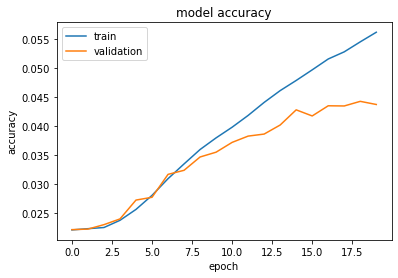

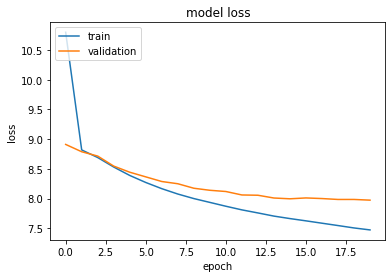

In [ ]:
import matplotlib.pyplot as plt
from keras.models import load_model

RETRIEVE=False

# construction du modèle RNN

if not RETRIEVE:

  model=build_model(one_hot_space_size,max_sequence_train,r_reg=reg)
  model.summary()

  start=datetime.datetime.now()
  print("start at :{}".format(str(start)))

  '''es=EarlyStopping(monitor='val_loss',mode='min', verbose=1,patience=10)     
  plot_model(model, to_file='model_lstm.png')'''

  history=model.fit_generator(generator=training_generator,validation_data=validation_generator,epochs=epochs,use_multiprocessing=False,verbose=2)
      
  stop=datetime.datetime.now()
  print("elapsed time for training model: {}".format(str(stop-start)))

  # sauvegarde du modèle
  model.save(my_path+'model_LSTM_'+str(LSTM_size)+'_shift_'+str(Shift)+'_lastFM_history_user_'+str(max_sequence_train)+'_index_start_1.h5')
  print(history.history.keys())
  # summarize history of accuracy
  plt.plot(history.history['sparse_categorical_accuracy'])
  plt.plot(history.history['val_sparse_categorical_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

else:
  model=load_model(my_path+'model_LSTM_'+str(LSTM_size)+'_shift_'+str(Shift)+'_lastFM_history_user_'+str(max_sequence_train)+'_index_start_1.h5')


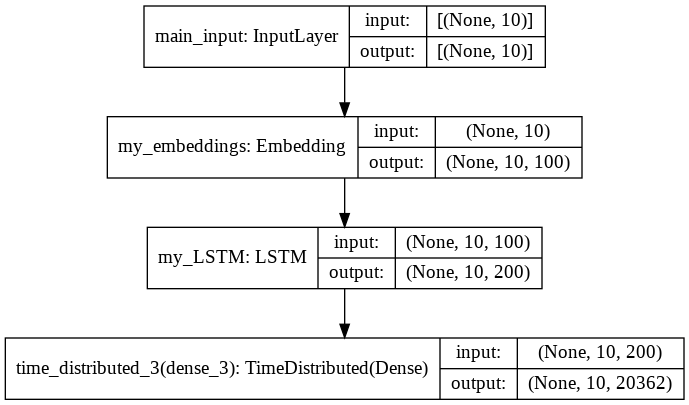

In [ ]:
# affichage model
dot_img_file = my_path+'model_LSTM_targetten'+str(LSTM_size)+'_shift_'+str(Shift)+'_lastFM_history_user_'+str(max_sequence_train)+'.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

## init prediction

In [ ]:
# echantillonnage
sample_test_0=[user for user in data_test_top1000_without_doublon.index if (user%10<10)]

In [ ]:
SHUFFLE_TEST=True

##Prediction

Méthode non itérative:



*   PRED_WITH_REPETITION = True : on prend le score le plus élevé de chaque vecteur de la séquence de la LSTM (10 vecteurs)
*   PRED_WITH_REPETITION = False : on prend les 10 score les plus élevés du dernier vecteur de la séquence de la LSTM 




In [ ]:
len(sample_test_0)

708

In [ ]:
ITER=True
#SHUFFLE_TEST=True


Méthode itérative: on prend le dernier élément (vecteur) de la sequence de la LSTM (puiqu'on a appris à prédire des séquence avec un décalage de un) puis on l'insére dans une séquence en dernière position (qui a alors une taille de 11) et on en lève le première élemnt à gauche - et on itère jusqu'à obtenir une nouvelle liste de 10 éléments.

In [ ]:
# prediction sur ensemble de test

new_max_sequence_label=10

if ITER: 
  couverture=[]

  count_user=0
  count_user_accepted=0
  dico_reco={}
  check_user=[]
  
  for userid in sample_test_0:
    # history
    # je ne retiens que les historiques qui ont 20 items
    count_user+=1
    if np.count_nonzero(data_test_top1000_without_doublon.loc[userid])>THRESHOLD_HISTORY:
      history_int=[song_top1000_2_int[k] for k in data_test_top1000_without_doublon.loc[userid]]
      count_user_accepted+=1
      check_user.append(userid)
      seq_in=history_int[-(max_sequence_train+num_prediction):-num_prediction] # sous-seq de longueur max_sequence_train
      if SHUFFLE_TEST:
        np.random.shuffle(seq_in)
      count_reco=0
      if Shift==1:
        save_index=[]
        while count_reco < num_prediction:
          x = sequence.pad_sequences([seq_in], maxlen=max_sequence_train)
          prediction=model.predict(x)
          # avoid item repetition"
          print("prediction",prediction)
          for index in save_index:
            prediction[0][index]=0
          index_target=np.argmax(prediction[0])
          print("index_target",index_target)
          save_index.append(index_target)
          couverture.append(index_target)
          if userid in dico_reco:
            dico_reco[userid].append(index_target)
          else:
            dico_reco[userid]=[index_target]    
          seq_in=seq_in[1:]+[index_target]
          count_reco+=1
      elif Shift==max_sequence_train:
        x = sequence.pad_sequences([seq_in], maxlen=max_sequence_train)
        prediction=model.predict(x)
        #ipdb.set_trace()
        prediction=prediction.reshape(prediction.shape[1],prediction.shape[2])
        #take all the values 
        temp_list=history_int[:max_sequence_train]
        for i in range(len(prediction)):
          itemid=np.argmax(prediction[i])
          while itemid in temp_list:
            # find the next one
            prediction[i][itemid]=0
            itemid=np.argmax(prediction[i])            
          temp_list.append(itemid)
          couverture.append(itemid)
          if userid in dico_reco:
            dico_reco[userid].append(itemid)
          else:
            dico_reco[userid]=[itemid]
      else:
        print("choose another value for {}".format(Shift)) 
        exit(-1)       
    if count_user%1000 == 0 :
      print(" user {} traité, nb total de users traité: {}".format(userid,count_user))
  couverture=np.unique(couverture)
  print("nb de user ayant une prediction",len(dico_reco))
  print("nb de user pour lesquels une prediction est calculée",count_user_accepted)
  print("nb de user pour lesquels on cherche une prediction",count_user)
  print("nb de reco <>",len(couverture))

nb de user ayant une prediction 708
nb de user pour lesquels une prediction est calculée 708
nb de user pour lesquels on cherche une prediction 708
nb de reco <> 723


In [ ]:
check_user[:10]

[475, 1452, 2534, 3462, 4059, 5009, 5024, 5179, 5482, 5487]

In [ ]:
# calcul max_DCG
import math
def log2(x):
 return(math.log(x,2))
max_DCG=0.
for i in range(1,num_prediction+1):
    max_DCG+=(2**(num_prediction+1-i)-1)/log2(i+1)
print("max_DCG",max_DCG)    

max_DCG 1571.4155855572703


In [ ]:
# calcul de la précision, sur ensemble de test
tab_AP=[]
precision_at_k=0.
MRR=0.
DCG=0.
max_DCG
count=0  
count_MRR=0 
count_DCG=0
average_DCG=0
label_set=set({})
new_max_sequence_label=10
for user in sample_test_0:
  if np.count_nonzero(data_test_top1000_without_doublon.loc[user])>THRESHOLD_HISTORY:
    # initialisation des variables
    tab_P=[]
    # calcul du nombre délement en commun rapporté à num_prediction (formule peut poser pb avec les répétition)
    history_int=[song_top1000_2_int[k] for k in data_test_top1000_without_doublon.loc[user] if k!=0 ]
    #print("history_int",history_int)
    label=history_int[-new_max_sequence_label:]  # on prend les max_sequence_label derniers...ceux d'avant ont été entré pour demander une prédiction
    #print(label)
    label_set.update(set(label))
    #input('wait')
    #retrieved_song_index=set(label)&set(dico_reco[user])
    # car pas de doublon
    retrieved_song=[x for x in dico_reco[user] if x in label]
    # compactage pour ne pas compter les répétitions
    retrieve_out_repet=[]
    for x in retrieved_song:
      if x not in retrieve_out_repet:
        retrieve_out_repet.append(x)
      else:
        continue 
    retrieved_song=retrieve_out_repet    
    #print("retrieved",retrieved_song)
    #ipdb.set_trace()

    #precision@(num_prediction) 
    for song_index in retrieved_song:
      precision_at_k+=min(label.count(song_index),dico_reco[user].count(song_index))
      #print("precision",precision_at_k)
    count+=1
    
    #AP@k
    # d'après https://medium.com/swlh/rank-aware-recsys-evaluation-metrics-5191bba16832
    P=0.0
    for rank in range(1,min(num_prediction,len(label))+1):
        # calcul P@rank
        #print(" prediction for {}:{}".format(user,dico_reco[user]))
        #print("label",label)
        if dico_reco[user][rank-1] in label:
            P+=1.0
            AP_inter=P/rank
            tab_P.append(AP_inter)
            #print("P",P)
        else:
            continue

    if len(retrieved_song)!=0:
        AP=sum(tab_P)/len(retrieved_song)
    else:
        AP=0
    tab_AP.append(AP)  
    
    #MRR
    # see https://medium.com/swlh/rank-aware-recsys-evaluation-metrics-5191bba16832
    for song in dico_reco[user]:
      if song in label:
        MRR+=1.0/(dico_reco[user].index(song)+1)
        count_MRR+=1
        break
      else:
        continue  
    
    #NDCG  
    DCG=0
    for song in dico_reco[user]:
      if song in label:
        DCG+=(2**(num_prediction-label.index(song))-1)/log2(dico_reco[user].index(song)+2)
      else:
        continue
    DCG/=max_DCG
    average_DCG+=DCG    
          
    

  else:
    continue  
print(count)
print("precision",precision_at_k)
 
precision_at_k=float(precision_at_k)/float(count*num_prediction)
MRR=float(MRR)/float(count)
MAP=sum(tab_AP)/len(tab_AP)
average_DCG=float(average_DCG)/float(count)

print("nb d'items <> dans le label set : {}".format(len(label_set)))
print("precision at {} sur ensemble de train complet égale à {}".format(num_prediction,precision_at_k))
print("nommbre de user sur lequel la precision peut être calculé : {}".format(count))
print("MRR sur ensemble de train complet égale à {}".format(MRR))
print("nombre de user sur lesquel MRR peut être calculé : {}".format(count_MRR))
print("MAP sur ensemble de train complet égale à {}".format(MAP))
print("nommbre de user sur lequel MAP peut être calculé : {}".format(len(tab_AP)))
print("NDCG sur ensemble de train complet égale à {}".format(average_DCG))
print("nommbre d'item pour lequel DCG peut être calculé : {}".format(count))
print("couverture_ coverage: {}".format(len(couverture)/len(label_set)))


print("nombre de user pris en compte : {}".format(count))

708
precision 713.0
nb d'items <> dans le label set : 2541
precision at 10 sur ensemble de train complet égale à 0.10070621468926554
nommbre de user sur lequel la precision peut être calculé : 708
MRR sur ensemble de train complet égale à 0.20703468298807284
nombre de user sur lesquel MRR peut être calculé : 420
MAP sur ensemble de train complet égale à 0.19862862635638068
nommbre de user sur lequel MAP peut être calculé : 708
NDCG sur ensemble de train complet égale à 0.056667368540680364
nommbre d'item pour lequel DCG peut être calculé : 708
couverture_ coverage: 0.2845336481700118
nombre de user pris en compte : 708


In [ ]:
average_measure['PREC'].append([SHUFFLE_TEST,round(precision_at_k,4)])
average_measure['MAP'].append([SHUFFLE_TEST,round(MAP,4)])
average_measure['MRR'].append([SHUFFLE_TEST,round(MRR,4)])
average_measure['NDCG'].append([SHUFFLE_TEST,round(average_DCG,4)])
average_measure['recall'].append([SHUFFLE_TEST,round(len(couverture)/len(label_set),4)])

In [ ]:
average_measure

{'MAP': [[False, 0.2032], [True, 0.1986]],
 'MRR': [[False, 0.215], [True, 0.207]],
 'NDCG': [[False, 0.0577], [True, 0.0567]],
 'PREC': [[False, 0.1007], [True, 0.1007]],
 'recall': [[False, 0.2885], [True, 0.2845]]}

#Store dico recommendation


In [ ]:
import copy
dico_reco_sav=copy.deepcopy(dico_reco)

#Overlap between shuffle and not shuffle


In [ ]:
tab_count=[]
for user in dico_reco:
  # all reco being uniques we can use set without losing information
  tab_count.append(len(set(dico_reco[user])&(set(dico_reco_sav[user]))))

overlap=np.average(tab_count)/num_prediction


(array([  3.,  16.,  75., 180., 289.,   0., 327., 339., 203.,  67.,   5.]),
 array([ 1.        ,  1.81818182,  2.63636364,  3.45454545,  4.27272727,
         5.09090909,  5.90909091,  6.72727273,  7.54545455,  8.36363636,
         9.18181818, 10.        ]),
 <a list of 11 Patch objects>)

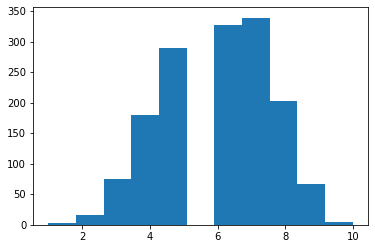

In [ ]:
import matplotlib.pyplot as plt
plt.hist(tab_count,11)

In [ ]:
print("overlap average",np.average(tab_count))

overlap average 6.008643617021277


In [ ]:
# True positiv among overlap, is it greater then the average ?
tab_nb_TP=[]
tab_nb_TP_no_shuffle=[]
tab_nb_TP_shuffle=[]
tab_nb_common=[]
for user in dico_reco:
  # all reco being uniques we can use set without losing information
  label_test =[song_top1000_2_int[k] for k in data_test_top1000_without_doublon.loc[user] if k!=0 ][-(num_prediction):]
  nb_TP=len(set(dico_reco[user])&set(dico_reco_sav[user])&set(label_test))
  nb_TP_no_shuffle=len(set(dico_reco[user])&set(label_test))
  nb_TP_shuffle=len(set(dico_reco_sav[user])&set(label_test))
  nb_common=len(set(dico_reco_sav[user])&set(dico_reco[user]))
  tab_nb_TP_shuffle.append(nb_TP_shuffle)
  tab_nb_TP_no_shuffle.append(nb_TP_no_shuffle)
  tab_nb_TP.append(nb_TP)
  tab_nb_common.append(nb_common)

In [ ]:
np.average(tab_nb_TP)/num_prediction

0.061635638297872344

In [ ]:
print(len(dico_reco)*num_prediction,np.sum(tab_nb_TP), np.sum(tab_nb_TP_no_shuffle), np.sum(tab_nb_TP_shuffle), np.sum(tab_nb_common))

15040 927 1243 1229 9037


In [ ]:
np.average(tab_nb_TP_no_shuffle)/num_prediction

0.08264627659574468

In [ ]:
np.average(tab_nb_TP_shuffle)/num_prediction

0.0817154255319149

In [ ]:
np.average(tab_nb_common)/num_prediction

0.6008643617021276

#Backup result

In [ ]:
import datetime
str(datetime.datetime.now())
print(count_user)

NameError: ignored

In [ ]:
#stockage des résultats
my_path_publication="/content/drive/My Drive/ColabNotebooks/publication/"

outfile="results.csv"
with open(my_path_publication+outfile, 'a') as f:
  f.write(str(datetime.datetime.now())+'\t'+str(data_select)+'\t'+str(round(precision_at_k,5))+'\t'+str(round(MRR,5))+'\t'+str(round(MAP,5))+'\t'+str(round(average_DCG,5))+\
          '\t'+str(count_user)+'\t'+str(max_sequence_train)+'\t'+str(max_sequence_label)+'\t'+str(THRESHOLD_ITEM)+'\t'+str(THRESHOLD_HISTORY)+'\t'+str(SHUFFLE_TEST)+\
          '\t'+str(LSTM_size)+'\t'+str(epochs)+'\t'+str(embedding_size)+'\t'+str(dropout_lstm_value)+'\t'+str(dropout_layer_value)+'\t'+str(reg)+\
          '\t'+str(ratio_sampling_top)+'\t'+str(num_prediction)+'\t'+str(Shift)+'\t'+str(batchsize)+'\t'+'target_ten_lastFM_1k_LSTM_Embeddings_multilabel_session_dataset_filtered_item.ipynb'+'\n')
f.close()

NameError: ignored

#Inference

In [ ]:
# Filtrage test pour les utilisateurs à historique > 20
data_test_above_20=[]
for i in data_test_top1000_without_doublon.index:
  #print(data_test.loc[i])
  if np.count_nonzero(data_test_top1000_without_doublon.loc[i])>THRESHOLD_HISTORY:
    data_test_above_20.append(list(data_test_top1000_without_doublon.loc[i]))
  

In [ ]:
len(data_test_top1000_without_doublon)

126559

In [ ]:
[song_top1000_2_int[k] for k in data_test_above_20[1154] if k!=0]

NameError: ignored

In [ ]:
# inférence
couverture=[]
SHUFFLE_TEST=True
dico_inf={}
dico_inf_shuffle={}
#user=np.random.choice(list(range(len(data_test_above_20))),1)[0]
user=1154
print("user",user)
history_int=[song_top1000_2_int[k] for k in data_test_above_20[user] if k!=0]
seq_in=history_int[-(max_sequence_train+num_prediction):-num_prediction] # sous-seq de longueur max_sequence_train
print("seq_in int", seq_in)
if SHUFFLE_TEST:
  np.random.shuffle(seq_in)
print("seq_in int", seq_in)
if ITER:
  if Shift==1:
    save_index=history_int[:max_sequence_train]
    count_reco=0
    while count_reco < num_prediction:
      x = sequence.pad_sequences([seq_in], maxlen=max_sequence_train)
      prediction=model.predict(x)
      for index in save_index:
        prediction[0][index]=0 
      index_target=np.argmax(prediction[0])
      save_index.append(index_target)
      #print("index_target",index_target)
      couverture.append(index_target)
      seq_in=seq_in[1:]+[index_target]
      print("seq_in",seq_in)
      count_reco+=1
  elif Shift==max_sequence_train:
    x = sequence.pad_sequences([seq_in], maxlen=max_sequence_train)
    prediction=model.predict(x)
    #ipdb.set_trace()
    prediction=prediction.reshape(prediction.shape[1],prediction.shape[2])
    #take all the values 
    temp_list=history_int[:max_sequence_train]
    for i in range(len(prediction)):
      itemid=np.argmax(prediction[i])
      while itemid in temp_list:
        # find the next one
        prediction[i][itemid]=0
        itemid=np.argmax(prediction[i])            
      temp_list.append(itemid)
      couverture.append(itemid)
  else:
    print("choose another value for {}".format(Shift)) 
    exit(-1)       
else:
  if Shift==1:
    count_reco=0
    x = sequence.pad_sequences([seq_in], maxlen=max_sequence_train)
    prediction=model.predict(x)
    liste_index_target=np.argsort(prediction[0])[::-1][:num_prediction]
    for index_target in liste_index_target:
      couverture.append(index_target)
if SHUFFLE:
  dico_inf_shuffle[user]=couverture
elif not SHUFFLE :
  dico_inf[user]=couverture 

print("prediction",couverture)
label=label=history_int[-new_max_sequence_label:]
print("label",label)
print("nb vrais positifs",len(set(couverture)&set(label)))
  

user 1154
seq_in int [597, 13574, 1917, 9060, 20047, 442, 10780, 12476, 5979, 2343]
seq_in int [597, 442, 10780, 5979, 12476, 13574, 9060, 2343, 1917, 20047]
prediction [25, 203, 999, 510, 524, 547, 6031, 2156, 1568, 3350]
label [2245, 753, 546, 827, 2350, 711, 703, 20048, 1168, 14086]
nb vrais positifs 0


In [ ]:
dico_reco

{475: [25, 12, 1, 78, 70, 232, 92, 158, 286, 895],
 739: [12, 25, 663, 694, 1251, 1261, 1115, 1270, 1223, 1498],
 746: [25, 1251, 307, 12, 1904, 1331, 1261, 694, 897, 865],
 1302: [25, 982, 49, 440, 620, 67, 411, 82, 1129, 974],
 1400: [2074, 155, 1867, 2951, 2824, 1812, 960, 180, 2500, 1588],
 1416: [25, 1438, 12, 2578, 3, 1041, 8032, 2174, 6646, 1386],
 1427: [25, 2074, 538, 620, 960, 43, 51, 748, 4792, 6843],
 1450: [25, 307, 1748, 3291, 3244, 1416, 642, 1694, 1279, 1908],
 1452: [25, 1219, 307, 1, 866, 3289, 1983, 1830, 1237, 3246],
 1466: [25, 307, 2247, 1168, 1237, 637, 1364, 1263, 1261, 528],
 1478: [25, 307, 1289, 637, 3291, 3303, 1033, 3429, 1279, 1248],
 1544: [25, 817, 293, 288, 71, 909, 1043, 1209, 2715, 286],
 1641: [25, 597, 3350, 2358, 999, 2050, 8316, 1563, 2243, 2245],
 1760: [1251, 1079, 1261, 694, 760, 946, 82, 293, 203, 193],
 2534: [25, 4383, 1588, 1417, 289, 288, 1291, 40, 909, 203],
 2679: [25, 10824, 3260, 101, 1041, 2305, 1985, 4484, 3038, 501],
 3462: [151, 12

Calcul du rappel et du MRR (cf. https://github.com/olesls/master_thesis/blob/master/code/test_util.py)

# Etude du loss





*   Affichage des valeurs du loss sur l'ensemble de validation

*   En effet il peut arriver que celui-ci ne suive pas la mêmetendance que celle du train

*   Il s'agit d'identifier d'éventuels irrégularités











Calcul de la cross entropy sur toutes les valeurs du dataset de validation

In [ ]:
# étude du loss sur l'ensemble de validation
# les labels sont fournis par le dictionnaire labels_valid
# les predictions sont à construire
from keras import utils
tab_loss=[]
tab_yhat=[]
tab_ytrue=[]

cce = tf.keras.losses.CategoricalCrossentropy()
scce = tf.keras.losses.SparseCategoricalCrossentropy()
for row in validation_generator:
  for i in range(len(row[0])):
    seq=sequence.pad_sequences([row[0][i]], maxlen=max_sequence_train)
    y_hat=model.predict(seq)
    y_true=row[1][i]
    loss=scce(tf.convert_to_tensor(y_true),tf.convert_to_tensor(y_hat[0]))
    tab_loss.append(keras.backend.eval(loss))
    if i == 10:
      break
  break     


In [ ]:
print(np.mean(tab_loss))

In [ ]:
# méthode plus rapide...
tab_loss_log=[]
tab_yhat=[]
tab_ytrue=[]
real_loss=0

count=0
for row in validation_generator:
  for i in range(len(row[0])):
    seq=sequence.pad_sequences([row[0][i]], maxlen=max_sequence_train)
    y_hat=model.predict(seq)
    y_true=row[1][i]
    real_loss=0
    for i in range(len(y_hat[0])):
      real_loss+=-np.log(y_hat[0][i][y_true[i][0]])
    tab_loss_log.append(real_loss/len(y_hat[0]))
    count+=1
    
  if count%1000 == 0:
    print(count)  
    

In [ ]:
plt.hist(tab_loss_log)

In [ ]:
plt.hist(tab_loss_log,range=(1,13),bins=30)

In [ ]:
from scipy import stats
stats.describe(tab_loss_log)

In [ ]:
# moyenne loss par batch
tab_loss_log_mean=[]
nb_batch=int(len(tab_loss_log)/batchsize)
for i in range(nb_batch):
  tab_loss_log_mean.append(np.average(tab_loss_log[i*batchsize:(i+1)*batchsize]))
len(tab_loss_log_mean)

In [ ]:
stats.describe(tab_loss_log_mean)

In [ ]:
plt.hist(tab_loss_log_mean)

# Petits examples sur la categorical cross entropy

In [ ]:
loss = scce(
  tf.convert_to_tensor([0, 1, 2]),
  tf.convert_to_tensor([[.9, .05, .05], [.5, .89, .6], [.05, .01, .94]]))
print('Loss: ', K.get_value(loss))  # Loss: 0.3239
loss = cce(
  tf.convert_to_tensor([[1,0,0],[0,1,0],[0,0,1]]),
  tf.convert_to_tensor([[.9, .05, .05], [.5, .89, .6], [.05, .01, .94]]))
print('Loss: ', K.get_value(loss))  # Loss: 0.3239

In [ ]:
import keras.backend as K

test_cce = tf.keras.losses.CategoricalCrossentropy()
test_scce = tf.keras.losses.SparseCategoricalCrossentropy()
tab_labels=[0,1,2,3,4,5,6,7,8,9]
y_true=[0,0,0,1,0,0,0,0,0,0]
y_true_sparse=[3]

y_hat=[0.22,0.01,0.01,0.7,0.01,0.01,0.01,0.01,0.01,0.01]
K.eval(test_cce(y_true,y_hat))
K.eval(test_scce(tf.convert_to_tensor(y_true_sparse),tf.convert_to_tensor(y_hat)))


In [ ]:
from sklearn.metrics import log_loss
log_loss(y_true_sparse,[y_hat], labels=tab_labels)

In [ ]:
from IPython.display import Javascript
Javascript("Jupyter.notebook.execute_cells([48])")